In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, f1_score, recall_score,
                             precision_score, accuracy_score)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
import warnings
warnings.filterwarnings('ignore')

Loading & Preparing Data

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/SumantaSethi/Bank-Customer-Churn-Prediction/main/Churn_Modelling_Clean.csv')

X = df.drop('Exited', axis=1)
y = df['Exited']

print(f"Dataset shape: {X.shape}")
print(f"\nClass distribution BEFORE SMOTE:")
print(y.value_counts())
print(f"Imbalance ratio: {y.value_counts()[0] / y.value_counts()[1]:.2f}:1")

Dataset shape: (10000, 10)

Class distribution BEFORE SMOTE:
Exited
0    7963
1    2037
Name: count, dtype: int64
Imbalance ratio: 3.91:1


# ENCODE CATEGORICAL VARIABLES

In [3]:
X_encoded = X.copy()

le_geo = LabelEncoder()
X_encoded['Geography'] = le_geo.fit_transform(X['Geography'])

le_gender = LabelEncoder()
X_encoded['Gender'] = le_gender.fit_transform(X['Gender'])

# TRAIN-TEST SPLIT

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

Training set: 7000 samples
Test set: 3000 samples


# APPLY SMOTE TO TRAINING DATA

In [5]:
print("\nWhat is SMOTE?")
print("- SMOTE creates synthetic samples of the minority class")
print("- It finds k-nearest neighbors of minority samples")
print("- Creates new samples along the line connecting neighbors")
print("- Balances the dataset for better model training")

print("\nClass distribution in TRAINING set BEFORE SMOTE:")
print(y_train.value_counts())

# Apply SMOTE only to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nClass distribution in TRAINING set AFTER SMOTE:")
print(pd.Series(y_train_resampled).value_counts())
print(f"\n✅ Training data is now balanced!")
print(f"   Original training size: {len(y_train)}")
print(f"   Resampled training size: {len(y_train_resampled)}")

print("\n⚠️ IMPORTANT:")
print("   - SMOTE is ONLY applied to TRAINING data")
print("   - TEST data remains UNTOUCHED (reflects real-world distribution)")
print("   - This prevents data leakage and ensures valid evaluation")


What is SMOTE?
- SMOTE creates synthetic samples of the minority class
- It finds k-nearest neighbors of minority samples
- Creates new samples along the line connecting neighbors
- Balances the dataset for better model training

Class distribution in TRAINING set BEFORE SMOTE:
Exited
0    5574
1    1426
Name: count, dtype: int64

Class distribution in TRAINING set AFTER SMOTE:
Exited
0    5574
1    5574
Name: count, dtype: int64

✅ Training data is now balanced!
   Original training size: 7000
   Resampled training size: 11148

⚠️ IMPORTANT:
   - SMOTE is ONLY applied to TRAINING data
   - TEST data remains UNTOUCHED (reflects real-world distribution)
   - This prevents data leakage and ensures valid evaluation


# CREATE SVM PIPELINE WITH SCALING

In [6]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(random_state=42, probability=True))
])

print("Pipeline created:")
print(pipeline)

Pipeline created:
Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', SVC(probability=True, random_state=42))])


In [17]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler # Ensure StandardScaler is accessible

# Define model with pipeline that includes SMOTE
model_s = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('classifier', SVC(random_state=42, probability=True)) # Added probability=True
])

model_s

Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('classifier', SVC(probability=True, random_state=42))])

# HYPERPARAMETER TUNING

In [8]:
param_grid = {
    'classifier__C': [0.1, 1, 10],  # Regularization parameter
    'classifier__kernel': ['rbf', 'linear'],  # Kernel type
    'classifier__gamma': ['scale', 'auto', 0.1, 1]  # Kernel coefficient
}

print("\nParameter grid:")
for param, values in param_grid.items():
    print(f"   {param}: {values}")

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,  # 3-fold CV (SVM is computationally expensive)
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

print("\nStarting Grid Search on SMOTE-resampled data...")
print("(This may take several minutes due to SVM complexity)")

grid_search.fit(X_train_resampled, y_train_resampled)

print(f"\n✅ Grid Search completed!")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV recall score: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_


Parameter grid:
   classifier__C: [0.1, 1, 10]
   classifier__kernel: ['rbf', 'linear']
   classifier__gamma: ['scale', 'auto', 0.1, 1]

Starting Grid Search on SMOTE-resampled data...
(This may take several minutes due to SVM complexity)
Fitting 3 folds for each of 24 candidates, totalling 72 fits

✅ Grid Search completed!
Best parameters: {'classifier__C': 10, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Best CV recall score: 0.8129


In [9]:
# Create the GridSearchCV model
# Create the GridSearch estimator along with a parameter object containing the values to adjust
from sklearn.model_selection import GridSearchCV

param_grid = {'svc__kernel' : ['linear', 'rbf', 'poly', 'sigmoid'],
              'svc__C': [0.0005,0.001, 0.01, 0.1, 0.5],
              'svc__gamma': [5, 1, 0.1, 0.01]}
grid_s = GridSearchCV(model_s, param_grid, verbose=3, cv= 5, n_jobs=4)

In [14]:
param_grid_corrected = {
    'classifier__kernel' : ['rbf', 'linear'],
    'classifier__C': [0.01, 0.1, 1],
    'classifier__gamma': ['scale', 0.1]
}

# Re-initialize GridSearchCV with the corrected parameter grid
# Ensure model_s is accessible from previous cells
grid_s = GridSearchCV(model_s, param_grid_corrected, verbose=3, cv=3, n_jobs=4)

# Fit the grid search model to the training data
print("\nStarting Grid Search on training data...")
grid_s.fit(X_train, y_train)

print(f"\n✅ Grid Search completed!")
print(f"Best parameters: {grid_s.best_params_}")
print(f"Best CV recall score: {grid_s.best_score_:.4f}")


Starting Grid Search on training data...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

✅ Grid Search completed!
Best parameters: {'classifier__C': 1, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Best CV recall score: 0.7864


# Evaluation

In [19]:
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("📊 MODEL PERFORMANCE METRICS:")
print(f"   Accuracy:  {accuracy:.4f}")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f} ⭐ (Primary metric for churn)")
print(f"   F1 Score:  {f1:.4f}")
print(f"   ROC-AUC:   {roc_auc:.4f}")

print("\n📋 DETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred,
                          target_names=['Stayed', 'Churned']))

📊 MODEL PERFORMANCE METRICS:
   Accuracy:  0.7930
   Precision: 0.4938
   Recall:    0.6530 ⭐ (Primary metric for churn)
   F1 Score:  0.5624
   ROC-AUC:   0.8186

📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      Stayed       0.90      0.83      0.86      2389
     Churned       0.49      0.65      0.56       611

    accuracy                           0.79      3000
   macro avg       0.70      0.74      0.71      3000
weighted avg       0.82      0.79      0.80      3000



# CONFUSION MATRIX ANALYSIS

In [20]:
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("\nConfusion Matrix Breakdown:")
print(f"   True Negatives (TN):  {tn} - Correctly predicted 'Stayed'")
print(f"   False Positives (FP): {fp} - Incorrectly predicted 'Churned'")
print(f"   False Negatives (FN): {fn} - Incorrectly predicted 'Stayed' ⚠️ COSTLY!")
print(f"   True Positives (TP):  {tp} - Correctly predicted 'Churned' ✅")

print(f"\n📊 Key Metrics Explained:")
print(f"   Recall = TP / (TP + FN) = {tp} / ({tp} + {fn}) = {recall:.4f}")
print(f"   → Out of {tp + fn} actual churners, we caught {tp} ({recall*100:.1f}%)")
print(f"   → We missed {fn} churners ({(fn/(tp+fn))*100:.1f}%)")


Confusion Matrix Breakdown:
   True Negatives (TN):  1980 - Correctly predicted 'Stayed'
   False Positives (FP): 409 - Incorrectly predicted 'Churned'
   False Negatives (FN): 212 - Incorrectly predicted 'Stayed' ⚠️ COSTLY!
   True Positives (TP):  399 - Correctly predicted 'Churned' ✅

📊 Key Metrics Explained:
   Recall = TP / (TP + FN) = 399 / (399 + 212) = 0.6530
   → Out of 611 actual churners, we caught 399 (65.3%)
   → We missed 212 churners (34.7%)


# VISUALIZATIONS

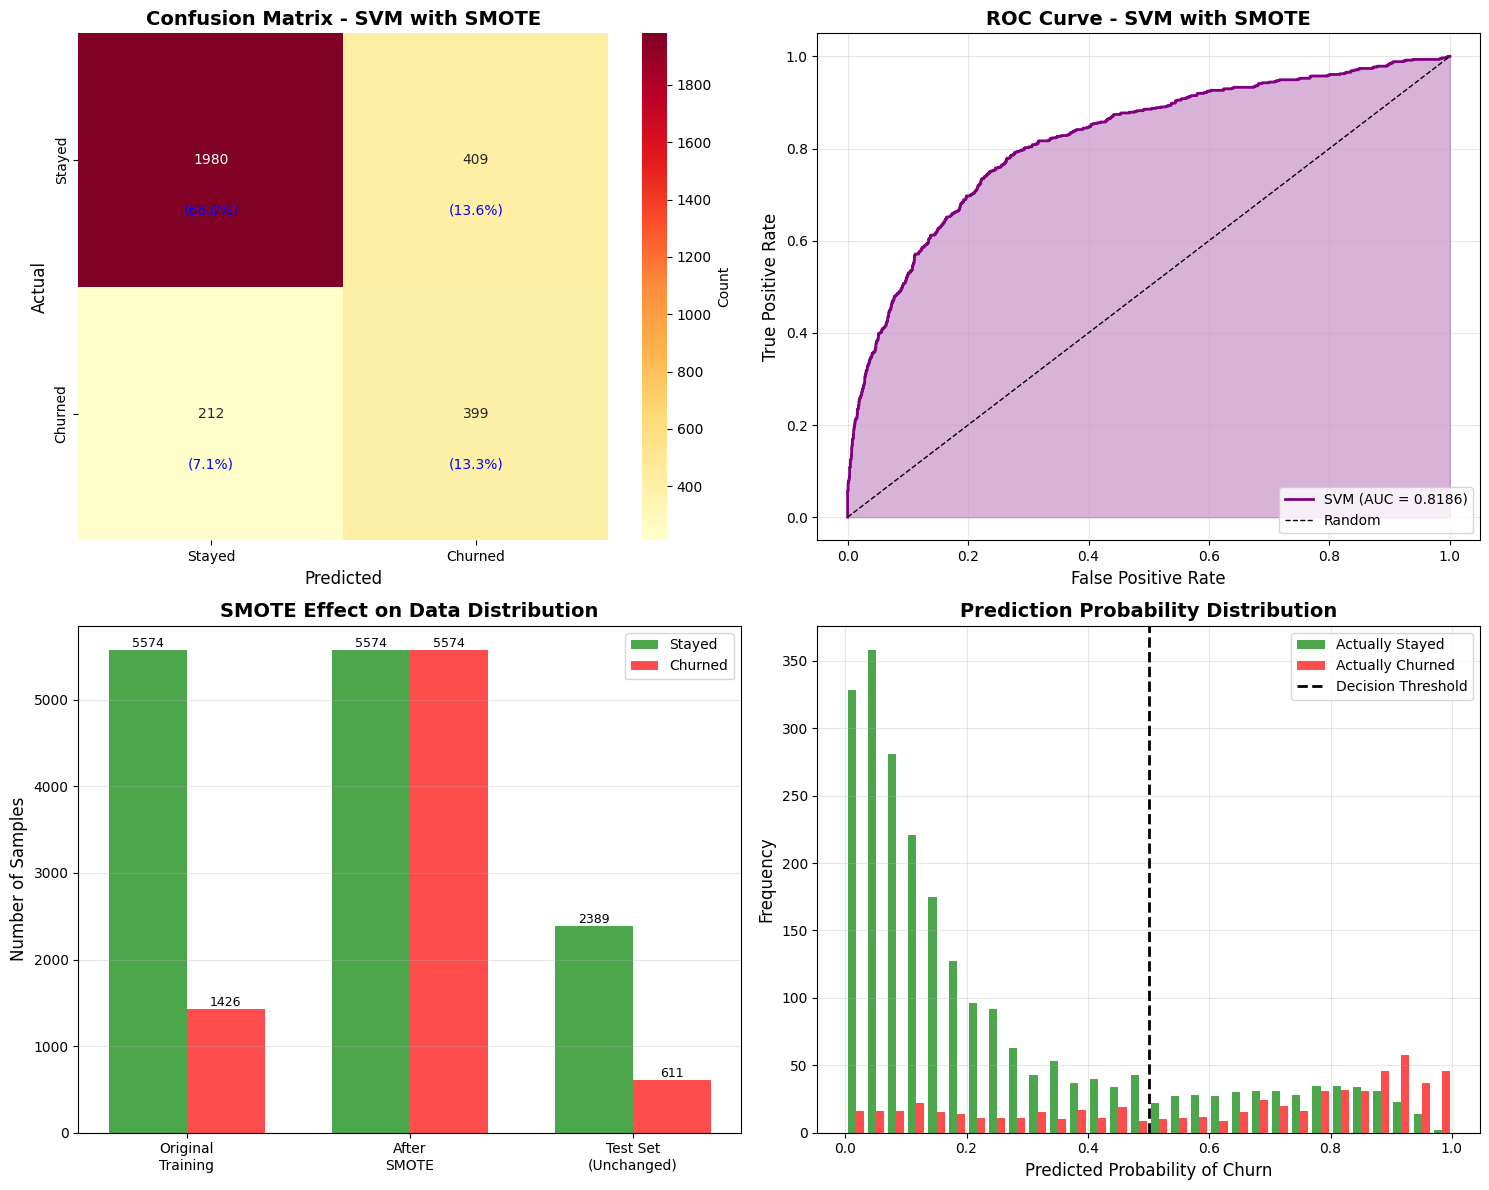

In [23]:
import os

# Create the directory if it doesn't exist
output_dir = 'models'
os.makedirs(output_dir, exist_ok=True)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd', ax=axes[0, 0],
            xticklabels=['Stayed', 'Churned'],
            yticklabels=['Stayed', 'Churned'],
            cbar_kws={'label': 'Count'})
axes[0, 0].set_title('Confusion Matrix - SVM with SMOTE',
                     fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Actual', fontsize=12)
axes[0, 0].set_xlabel('Predicted', fontsize=12)

# Add percentage annotations
for i in range(2):
    for j in range(2):
        percentage = cm[i, j] / cm.sum() * 100
        axes[0, 0].text(j + 0.5, i + 0.7, f'({percentage:.1f}%)',
                        ha='center', va='center', fontsize=10, color='blue')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
axes[0, 1].plot(fpr, tpr, linewidth=2, label=f'SVM (AUC = {roc_auc:.4f})', color='purple')
axes[0, 1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0, 1].fill_between(fpr, tpr, alpha=0.3, color='purple')
axes[0, 1].set_xlabel('False Positive Rate', fontsize=12)
axes[0, 1].set_ylabel('True Positive Rate', fontsize=12)
axes[0, 1].set_title('ROC Curve - SVM with SMOTE', fontsize=14, fontweight='bold')
axes[0, 1].legend(loc='lower right')
axes[0, 1].grid(alpha=0.3)

# SMOTE Effect Visualization
class_distribution = pd.DataFrame({
    'Stage': ['Original\nTraining', 'After\nSMOTE', 'Test Set\n(Unchanged)'],
    'Stayed': [y_train.value_counts()[0],
               pd.Series(y_train_resampled).value_counts()[0],
               y_test.value_counts()[0]],
    'Churned': [y_train.value_counts()[1],
                pd.Series(y_train_resampled).value_counts()[1],
                y_test.value_counts()[1]]
})

x = np.arange(len(class_distribution['Stage']))
width = 0.35

bars1 = axes[1, 0].bar(x - width/2, class_distribution['Stayed'], width,
                       label='Stayed', color='green', alpha=0.7)
bars2 = axes[1, 0].bar(x + width/2, class_distribution['Churned'], width,
                       label='Churned', color='red', alpha=0.7)

axes[1, 0].set_ylabel('Number of Samples', fontsize=12)
axes[1, 0].set_title('SMOTE Effect on Data Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(class_distribution['Stage'])
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(height)}',
                        ha='center', va='bottom', fontsize=9)

# Prediction Probability Distribution
axes[1, 1].hist([y_pred_proba[y_test==0], y_pred_proba[y_test==1]],
               bins=30, label=['Actually Stayed', 'Actually Churned'],
               color=['green', 'red'], alpha=0.7)
axes[1, 1].axvline(x=0.5, color='black', linestyle='--', linewidth=2,
                   label='Decision Threshold')
axes[1, 1].set_xlabel('Predicted Probability of Churn', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Prediction Probability Distribution', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('models/svm_smote_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

# COMPARE WITHOUT SMOTE

In [26]:
svc_params = {k.replace('classifier__', ''): v for k, v in grid_search.best_params_.items()}

svm_no_smote = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(random_state=42, probability=True, **svc_params))
])

# Use same best params but train on original imbalanced data
svm_no_smote.fit(X_train, y_train)
y_pred_no_smote = svm_no_smote.predict(X_test)

recall_no_smote = recall_score(y_test, y_pred_no_smote)
f1_no_smote = f1_score(y_test, y_pred_no_smote)

print("\n📊 COMPARISON:")
print(f"                    With SMOTE    Without SMOTE")
print(f"   Recall:          {recall:.4f}        {recall_no_smote:.4f}")
print(f"   F1 Score:        {f1:.4f}        {f1_no_smote:.4f}")
print(f"\n   Improvement:     {(recall - recall_no_smote)*100:+.2f}%       {(f1 - f1_no_smote)*100:+.2f}%")

print("\n✅ SMOTE Impact:")
if recall > recall_no_smote:
    print(f"   SMOTE improved recall by {(recall - recall_no_smote)*100:.1f}%")
    print("   This means we're catching MORE churners!")
else:
    print("   SMOTE did not improve recall in this case")


📊 COMPARISON:
                    With SMOTE    Without SMOTE
   Recall:          0.6530        0.4386
   F1 Score:        0.5624        0.5549

   Improvement:     +21.44%       +0.75%

✅ SMOTE Impact:
   SMOTE improved recall by 21.4%
   This means we're catching MORE churners!


# SAVE MODEL

In [27]:
joblib.dump(best_model, 'models/svm_smote.pkl')

# Save SMOTE transformer for potential future use
joblib.dump(smote, 'models/smote_transformer.pkl')

print("✅ Model saved to 'models/svm_smote.pkl'")
print("✅ SMOTE transformer saved to 'models/smote_transformer.pkl'")

print("\n" + "="*80)
print("SVM WITH SMOTE MODEL COMPLETED!")
print("="*80)

print("\n📊 FINAL SUMMARY:")
print(f"   Model: Support Vector Machine (SVM) with SMOTE")
print(f"   Kernel: {best_model.named_steps['classifier'].kernel}")
print(f"   Accuracy: {accuracy:.4f}")
print(f"   Recall: {recall:.4f} ⭐")
print(f"   F1 Score: {f1:.4f}")
print(f"   ROC-AUC: {roc_auc:.4f}")
print(f"\n   SMOTE Effect:")
print(f"   - Training samples increased from {len(y_train)} to {len(y_train_resampled)}")
print(f"   - Classes balanced: {pd.Series(y_train_resampled).value_counts().values}")
print(f"   - Improved model's ability to detect churners")

✅ Model saved to 'models/svm_smote.pkl'
✅ SMOTE transformer saved to 'models/smote_transformer.pkl'

SVM WITH SMOTE MODEL COMPLETED!

📊 FINAL SUMMARY:
   Model: Support Vector Machine (SVM) with SMOTE
   Kernel: rbf
   Accuracy: 0.7930
   Recall: 0.6530 ⭐
   F1 Score: 0.5624
   ROC-AUC: 0.8186

   SMOTE Effect:
   - Training samples increased from 7000 to 11148
   - Classes balanced: [5574 5574]
   - Improved model's ability to detect churners
